In [2]:
# --- Standard Library ---
import os
import warnings
import json
from collections import Counter

# --- Third-Party Libraries ---
import numpy as np
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from dotenv import load_dotenv

# --- Local Imports ---
from qiskit_quantum_simulator import QiskitQuantumSimulator

# --- Configurations ---
load_dotenv()
warnings.filterwarnings("ignore", category=UserWarning)
plt.rcParams['figure.dpi'] = 300

# --- Paths & Directories ---
BENCHMARK_QISKIT_DIR = os.getenv("BENCHMARK_QISKIT_DIR")

# --- API Token ---
IBM_TOKEN = os.getenv("IBM_API_TOKEN")

In [3]:
def hex_samples_to_counts(samples, num_bits):
    """Convert list of hex strings to binary counts."""
    bin_strings = [bin(int(s, 16))[2:].zfill(num_bits) for s in samples]
    return dict(Counter(bin_strings))

def plot_grouped_counts(sim_counts, real_counts, title, ax):
    """Plot side-by-side bars for sim and real counts on the given axis."""
    keys = sorted(set(sim_counts.keys()).union(real_counts.keys()))
    sim_vals = [sim_counts.get(k, 0) for k in keys]
    real_vals = [real_counts.get(k, 0) for k in keys]

    x = np.arange(len(keys))
    width = 0.35

    bars1 = ax.bar(x - width/2, real_vals, width, label='Actual', color='skyblue')
    bars2 = ax.bar(x + width/2, sim_vals, width, label='Simulated', color='orange')

    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(keys, rotation=45, ha='right')
    ax.legend()

    # Add count labels above bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

def run_and_plot_all_counts(algo_name: str, circuit, json_path="../actual_quantum_reading.json"):
    # Load real device job IDs
    with open(json_path, "r") as f:
        REAL_JOB_IDS = json.load(f)

    if algo_name not in REAL_JOB_IDS:
        raise ValueError(f"Algorithm '{algo_name}' not found in '{json_path}'.")

    # Run simulators
    simulator_results = {}
    for backend in ["ibm_brisbane", "ibm_sherbrooke"]:
        sim = QiskitQuantumSimulator(ibm_backend=backend)
        job = sim.run(circuit)
        result = job.result()
        simulator_results[backend] = result[0].data.c.get_counts()

    # Fetch real device results
    service = QiskitRuntimeService(
        channel='ibm_quantum',
        instance='ibm-q/open/main',
        token=IBM_TOKEN
    )

    real_results = {}
    for backend in ["ibm_brisbane", "ibm_sherbrooke"]:
        job_id = REAL_JOB_IDS[algo_name][backend]
        job = service.job(job_id)
        job_result = job.result()

        samples = job_result['results'][0]['data']['c']['samples']
        num_bits = job_result['results'][0]['data']['c']['num_bits']

        real_results[backend] = hex_samples_to_counts(samples, num_bits)

    # Plot grouped bar charts
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle(f"Measurement Results: {algo_name}", fontsize=16, weight='bold')

    plot_grouped_counts(simulator_results["ibm_brisbane"], real_results["ibm_brisbane"],
                        "ibm_brisbane: Real vs Simulated", axs[0])
    plot_grouped_counts(simulator_results["ibm_sherbrooke"], real_results["ibm_sherbrooke"],
                        "ibm_sherbrooke: Real vs Simulated", axs[1])

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save the figure
    output_dir = BENCHMARK_QISKIT_DIR
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"{algo_name}.png")
    plt.savefig(output_path, bbox_inches='tight')
    plt.show()


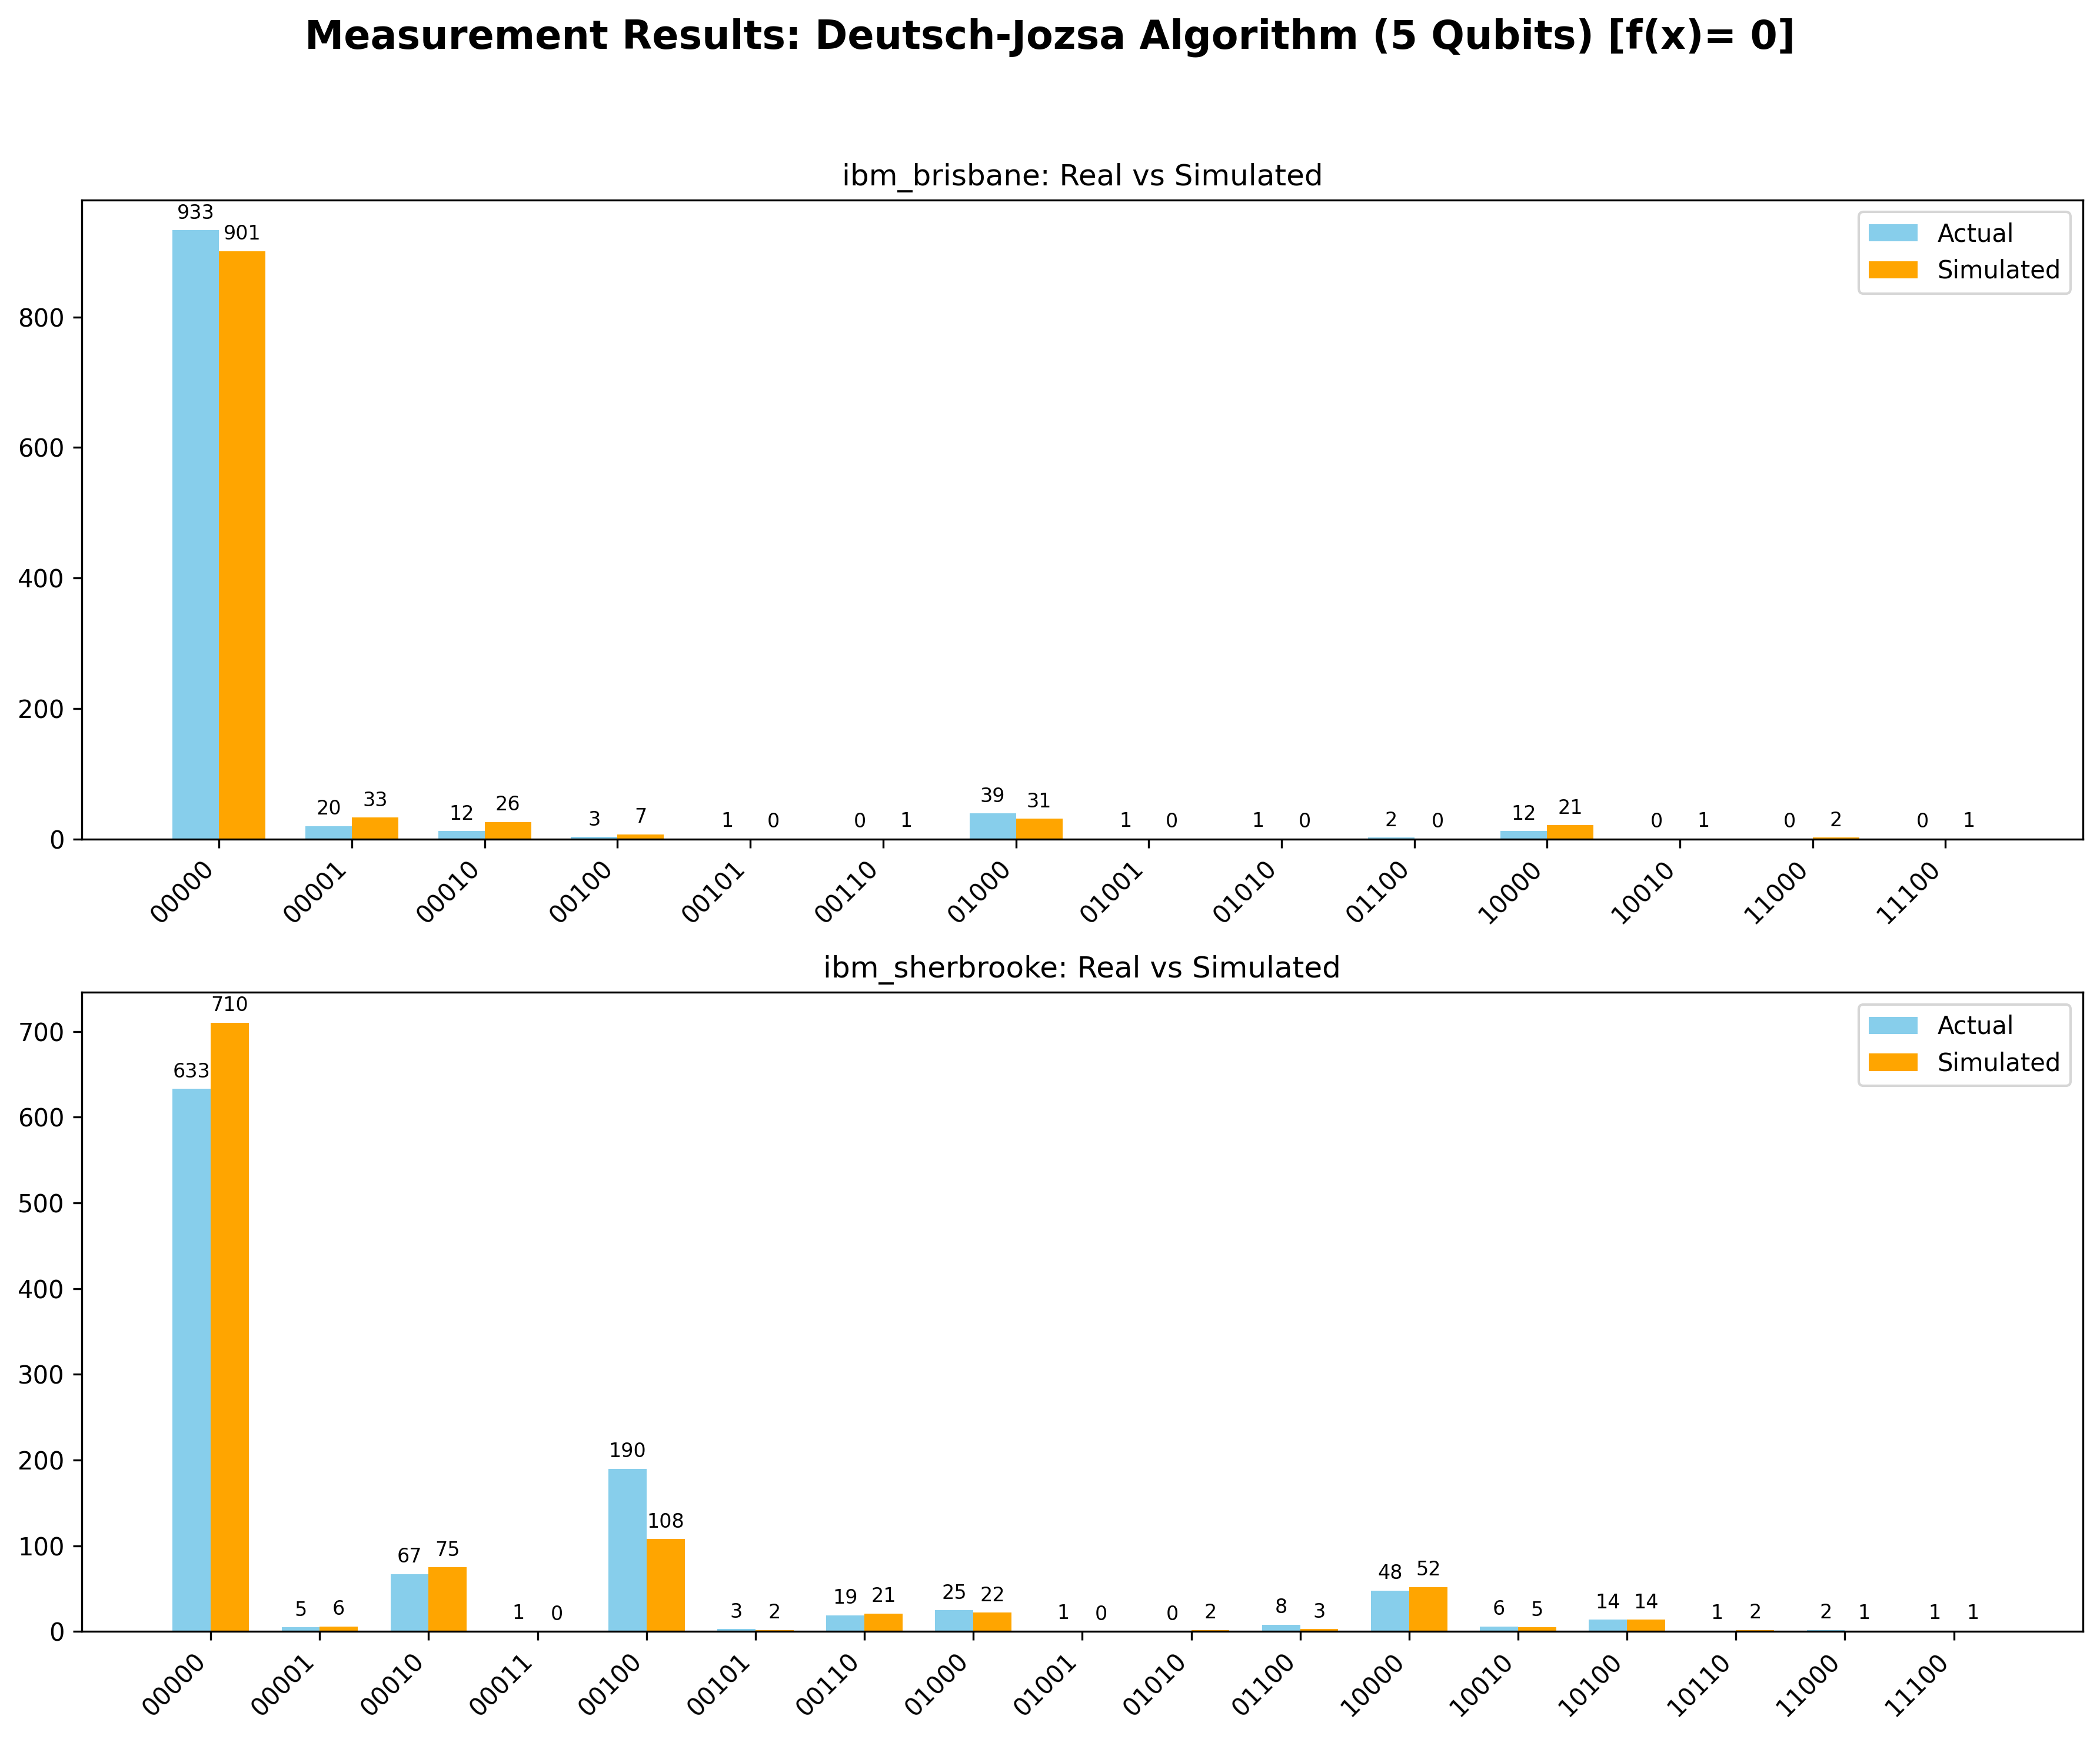

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
import numpy as np

qc = QuantumCircuit()

q = QuantumRegister(6, 'q')
c = ClassicalRegister(5, 'c')

qc.add_register(q)
qc.add_register(c)

qc.h(q[0])
qc.h(q[1])
qc.h(q[2])
qc.h(q[3])
qc.h(q[4])
qc.x(q[5])
qc.h(q[0])
qc.h(q[1])
qc.h(q[2])
qc.h(q[3])
qc.h(q[4])
qc.h(q[5])
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.measure(q[2], c[2])
qc.measure(q[3], c[3])
qc.measure(q[4], c[4])

run_and_plot_all_counts("Deutsch-Jozsa Algorithm (5 Qubits) [f(x)= 0]", circuit=qc)

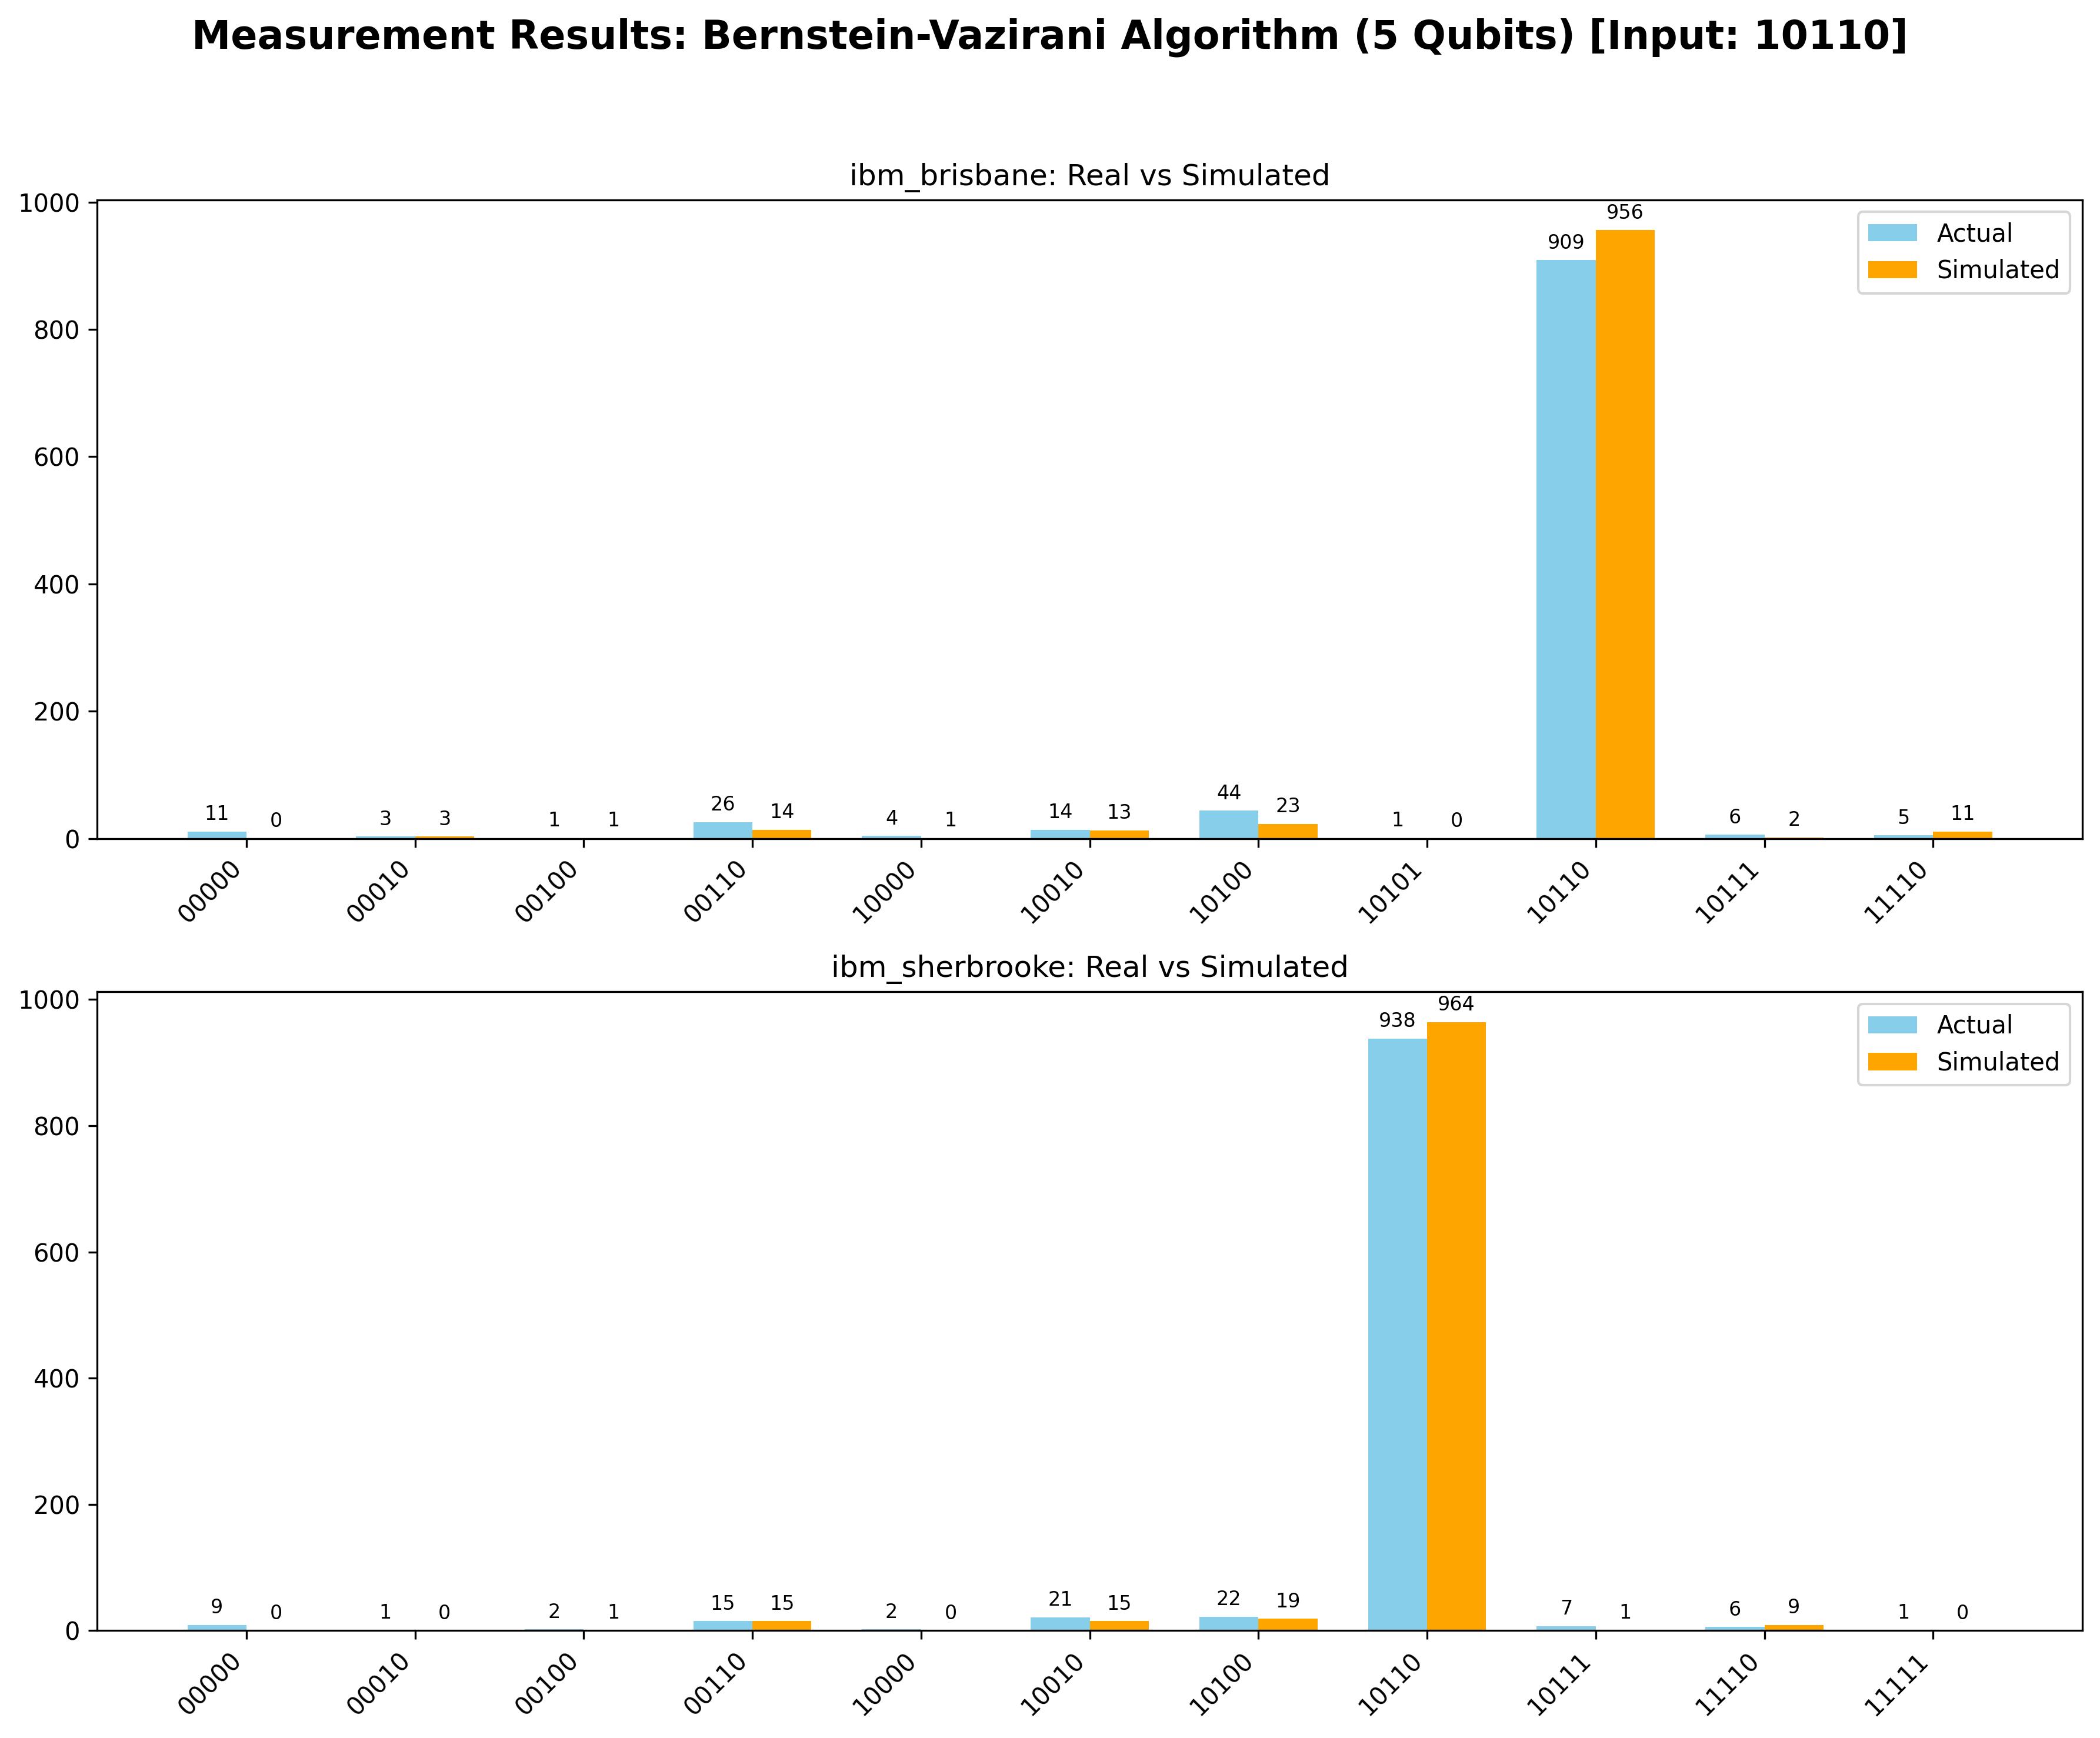

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
import numpy as np

qc = QuantumCircuit()

q = QuantumRegister(6, 'q')
c = ClassicalRegister(5, 'c')

qc.add_register(q)
qc.add_register(c)

qc.h(q[0])
qc.h(q[1])
qc.h(q[2])
qc.h(q[3])
qc.h(q[4])
qc.x(q[5])
qc.h(q[0])
qc.h(q[5])
qc.cx(q[1], q[5])
qc.h(q[1])
qc.cx(q[2], q[5])
qc.h(q[2])
qc.h(q[3])
qc.cx(q[4], q[5])
qc.h(q[4])
qc.h(q[5])
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.measure(q[2], c[2])
qc.measure(q[3], c[3])
qc.measure(q[4], c[4])

run_and_plot_all_counts("Bernstein-Vazirani Algorithm (5 Qubits) [Input: 10110]", circuit=qc)

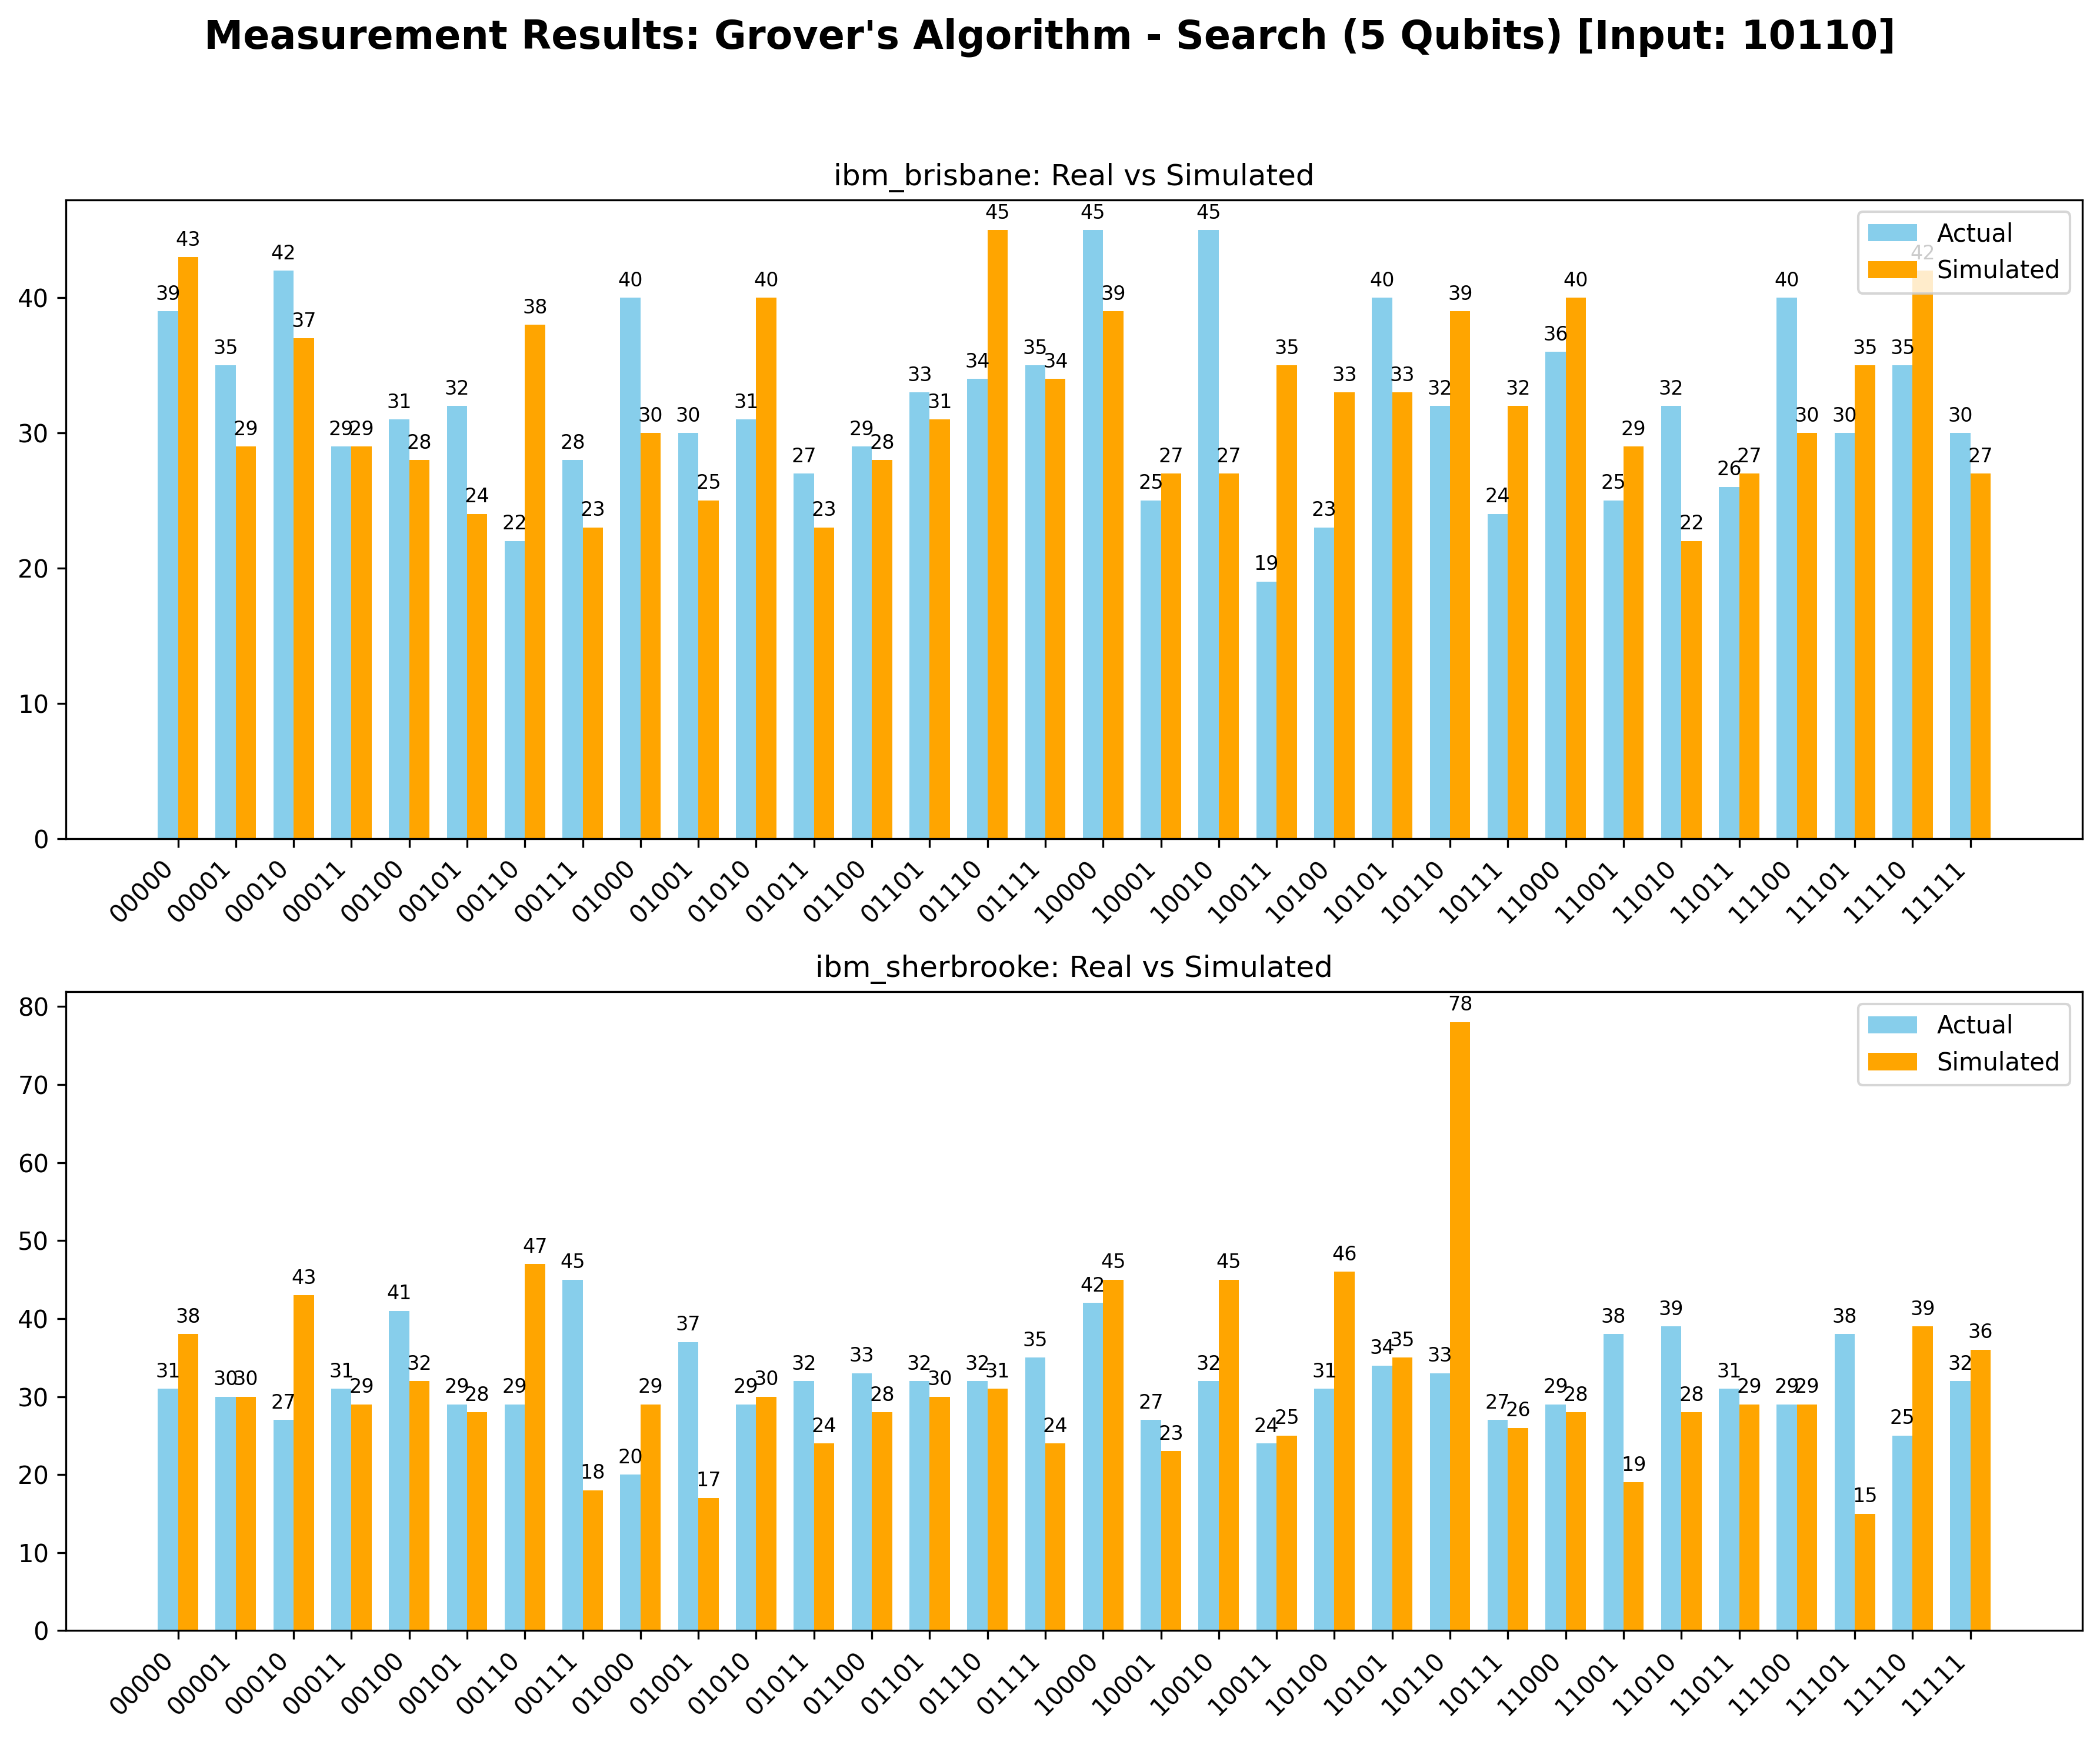

In [7]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
import numpy as np

qc = QuantumCircuit()

q = QuantumRegister(5, 'q')
c = ClassicalRegister(5, 'c')

qc.add_register(q)
qc.add_register(c)

qc.h(q[0])
qc.h(q[1])
qc.h(q[2])
qc.h(q[3])
qc.h(q[4])
qc.x(q[0])
qc.x(q[3])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 2, q[3], q[4])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.h(q[4])
qc.p(np.pi / 4, q[3])
qc.h(q[4])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.cp(-np.pi / 2, q[3], q[4])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.h(q[4])
qc.p(np.pi / 4, q[3])
qc.h(q[4])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.cp(np.pi / 8, q[0], q[4])
qc.cx(q[0], q[1])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[1], q[4])
qc.cx(q[0], q[1])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 8, q[1], q[4])
qc.cx(q[1], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[2], q[4])
qc.cx(q[0], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 8, q[2], q[4])
qc.cx(q[1], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[2], q[4])
qc.cx(q[0], q[2])
qc.h(q[4])
qc.x(q[0])
qc.h(q[1])
qc.h(q[4])
qc.h(q[0])
qc.x(q[1])
qc.cp(np.pi / 8, q[2], q[4])
qc.x(q[0])
qc.h(q[2])
qc.x(q[3])
qc.h(q[4])
qc.x(q[2])
qc.h(q[3])
qc.h(q[4])
qc.x(q[3])
qc.h(q[4])
qc.x(q[4])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 2, q[3], q[4])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.h(q[4])
qc.p(np.pi / 4, q[3])
qc.h(q[4])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.cp(-np.pi / 2, q[3], q[4])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.h(q[4])
qc.p(np.pi / 4, q[3])
qc.h(q[4])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.cp(np.pi / 8, q[0], q[4])
qc.cx(q[0], q[1])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[1], q[4])
qc.cx(q[0], q[1])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 8, q[1], q[4])
qc.cx(q[1], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[2], q[4])
qc.cx(q[0], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 8, q[2], q[4])
qc.cx(q[1], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[2], q[4])
qc.cx(q[0], q[2])
qc.h(q[4])
qc.x(q[0])
qc.x(q[1])
qc.h(q[4])
qc.h(q[0])
qc.h(q[1])
qc.cp(np.pi / 8, q[2], q[4])
qc.x(q[0])
qc.x(q[2])
qc.x(q[3])
qc.h(q[4])
qc.h(q[2])
qc.h(q[3])
qc.h(q[4])
qc.x(q[3])
qc.x(q[4])
qc.h(q[4])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 2, q[3], q[4])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.h(q[4])
qc.p(np.pi / 4, q[3])
qc.h(q[4])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.cp(-np.pi / 2, q[3], q[4])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.h(q[4])
qc.p(np.pi / 4, q[3])
qc.h(q[4])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.cp(np.pi / 8, q[0], q[4])
qc.cx(q[0], q[1])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[1], q[4])
qc.cx(q[0], q[1])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 8, q[1], q[4])
qc.cx(q[1], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[2], q[4])
qc.cx(q[0], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 8, q[2], q[4])
qc.cx(q[1], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[2], q[4])
qc.cx(q[0], q[2])
qc.h(q[4])
qc.x(q[0])
qc.h(q[1])
qc.h(q[4])
qc.h(q[0])
qc.x(q[1])
qc.cp(np.pi / 8, q[2], q[4])
qc.x(q[0])
qc.h(q[2])
qc.x(q[3])
qc.h(q[4])
qc.x(q[2])
qc.h(q[3])
qc.h(q[4])
qc.x(q[3])
qc.h(q[4])
qc.x(q[4])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 2, q[3], q[4])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.h(q[4])
qc.p(np.pi / 4, q[3])
qc.h(q[4])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.cp(-np.pi / 2, q[3], q[4])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.h(q[4])
qc.p(np.pi / 4, q[3])
qc.h(q[4])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.cp(np.pi / 8, q[0], q[4])
qc.cx(q[0], q[1])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[1], q[4])
qc.cx(q[0], q[1])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 8, q[1], q[4])
qc.cx(q[1], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[2], q[4])
qc.cx(q[0], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 8, q[2], q[4])
qc.cx(q[1], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[2], q[4])
qc.cx(q[0], q[2])
qc.h(q[4])
qc.x(q[0])
qc.x(q[1])
qc.h(q[4])
qc.h(q[0])
qc.h(q[1])
qc.cp(np.pi / 8, q[2], q[4])
qc.x(q[0])
qc.x(q[2])
qc.x(q[3])
qc.h(q[4])
qc.h(q[2])
qc.h(q[3])
qc.h(q[4])
qc.x(q[3])
qc.x(q[4])
qc.h(q[4])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 2, q[3], q[4])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.h(q[4])
qc.p(np.pi / 4, q[3])
qc.h(q[4])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.cp(-np.pi / 2, q[3], q[4])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.h(q[4])
qc.p(np.pi / 4, q[3])
qc.h(q[4])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.cp(np.pi / 8, q[0], q[4])
qc.cx(q[0], q[1])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[1], q[4])
qc.cx(q[0], q[1])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 8, q[1], q[4])
qc.cx(q[1], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[2], q[4])
qc.cx(q[0], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 8, q[2], q[4])
qc.cx(q[1], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[2], q[4])
qc.cx(q[0], q[2])
qc.h(q[4])
qc.x(q[0])
qc.h(q[1])
qc.h(q[4])
qc.h(q[0])
qc.x(q[1])
qc.cp(np.pi / 8, q[2], q[4])
qc.x(q[0])
qc.h(q[2])
qc.x(q[3])
qc.h(q[4])
qc.x(q[2])
qc.h(q[3])
qc.h(q[4])
qc.x(q[3])
qc.h(q[4])
qc.x(q[4])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 2, q[3], q[4])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.h(q[4])
qc.p(np.pi / 4, q[3])
qc.h(q[4])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.cp(-np.pi / 2, q[3], q[4])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.h(q[4])
qc.p(np.pi / 4, q[3])
qc.h(q[4])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.cp(np.pi / 8, q[0], q[4])
qc.cx(q[0], q[1])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[1], q[4])
qc.cx(q[0], q[1])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 8, q[1], q[4])
qc.cx(q[1], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[2], q[4])
qc.cx(q[0], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 8, q[2], q[4])
qc.cx(q[1], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[2], q[4])
qc.cx(q[0], q[2])
qc.h(q[4])
qc.x(q[0])
qc.x(q[1])
qc.h(q[4])
qc.h(q[0])
qc.h(q[1])
qc.cp(np.pi / 8, q[2], q[4])
qc.x(q[0])
qc.x(q[2])
qc.x(q[3])
qc.h(q[4])
qc.h(q[2])
qc.h(q[3])
qc.h(q[4])
qc.x(q[3])
qc.x(q[4])
qc.h(q[4])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 2, q[3], q[4])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.h(q[4])
qc.p(np.pi / 4, q[3])
qc.h(q[4])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.cp(-np.pi / 2, q[3], q[4])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.h(q[4])
qc.p(np.pi / 4, q[3])
qc.h(q[4])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.cp(np.pi / 8, q[0], q[4])
qc.cx(q[0], q[1])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[1], q[4])
qc.cx(q[0], q[1])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 8, q[1], q[4])
qc.cx(q[1], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[2], q[4])
qc.cx(q[0], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 8, q[2], q[4])
qc.cx(q[1], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[2], q[4])
qc.cx(q[0], q[2])
qc.h(q[4])
qc.x(q[0])
qc.h(q[1])
qc.h(q[4])
qc.h(q[0])
qc.x(q[1])
qc.cp(np.pi / 8, q[2], q[4])
qc.x(q[0])
qc.h(q[2])
qc.x(q[3])
qc.h(q[4])
qc.x(q[2])
qc.h(q[3])
qc.h(q[4])
qc.x(q[3])
qc.h(q[4])
qc.x(q[4])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 2, q[3], q[4])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.h(q[4])
qc.p(np.pi / 4, q[3])
qc.h(q[4])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, 0, np.pi, q[3])
qc.cp(-np.pi / 2, q[3], q[4])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.h(q[4])
qc.p(np.pi / 4, q[3])
qc.h(q[4])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[1], q[3])
qc.p(-np.pi / 4, q[3])
qc.cx(q[0], q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.p(np.pi / 4, q[3])
qc.cx(q[2], q[3])
qc.p(-np.pi / 4, q[3])
qc.u(np.pi / 2, -2 * np.pi, np.pi, q[3])
qc.cp(np.pi / 8, q[0], q[4])
qc.cx(q[0], q[1])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[1], q[4])
qc.cx(q[0], q[1])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 8, q[1], q[4])
qc.cx(q[1], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[2], q[4])
qc.cx(q[0], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(np.pi / 8, q[2], q[4])
qc.cx(q[1], q[2])
qc.h(q[4])
qc.h(q[4])
qc.cp(-np.pi / 8, q[2], q[4])
qc.cx(q[0], q[2])
qc.h(q[4])
qc.x(q[0])
qc.x(q[1])
qc.h(q[4])
qc.h(q[0])
qc.h(q[1])
qc.cp(np.pi / 8, q[2], q[4])
qc.x(q[2])
qc.x(q[3])
qc.h(q[4])
qc.h(q[2])
qc.h(q[3])
qc.h(q[4])
qc.x(q[4])
qc.h(q[4])
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.measure(q[2], c[2])
qc.measure(q[3], c[3])
qc.measure(q[4], c[4])

run_and_plot_all_counts("Grover's Algorithm - Search (5 Qubits) [Input: 10110]", circuit=qc)